## Import Necessary Libraries

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import ResNet50

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    f1_score
)

# set seeds for reproducibility

SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)


2026-01-02 17:44:10.458331: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1767375850.640924      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1767375850.698029      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1767375851.141277      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767375851.141316      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767375851.141319      55 computation_placer.cc:177] computation placer alr

In [2]:
# Define Dataset Paths

train_ds_path = '/kaggle/input/candle-image-data/Train'
test_ds_path = '/kaggle/input/candle-image-data/Test'

## Data Exploration & Visualization

Train Distribution: {'Down': 624, 'Up': 809} Total: 1433
Test Distribution: {'Down': 157, 'Up': 194} Total: 351


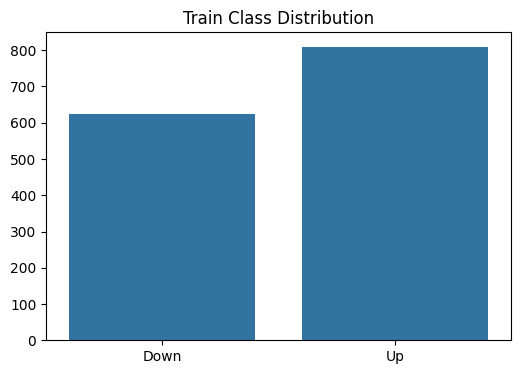

In [3]:
# count sample and class distributions

def count_images(path):
    counts = {}
    total = 0
    for cls in os.listdir(path):
        cls_path = os.path.join(path, cls)
        if os.path.isdir(cls_path):
            n = len(os.listdir(cls_path))
            counts[cls] = n
            total += n
    return counts, total

train_counts, train_total = count_images(train_ds_path)
test_counts, test_total   = count_images(test_ds_path)

print("Train Distribution:", train_counts, "Total:", train_total)
print("Test Distribution:", test_counts, "Total:", test_total)

# visualize class Imbalance

plt.figure(figsize=(6,4))
sns.barplot(x=list(train_counts.keys()), y=list(train_counts.values()))
plt.title("Train Class Distribution")
plt.show()

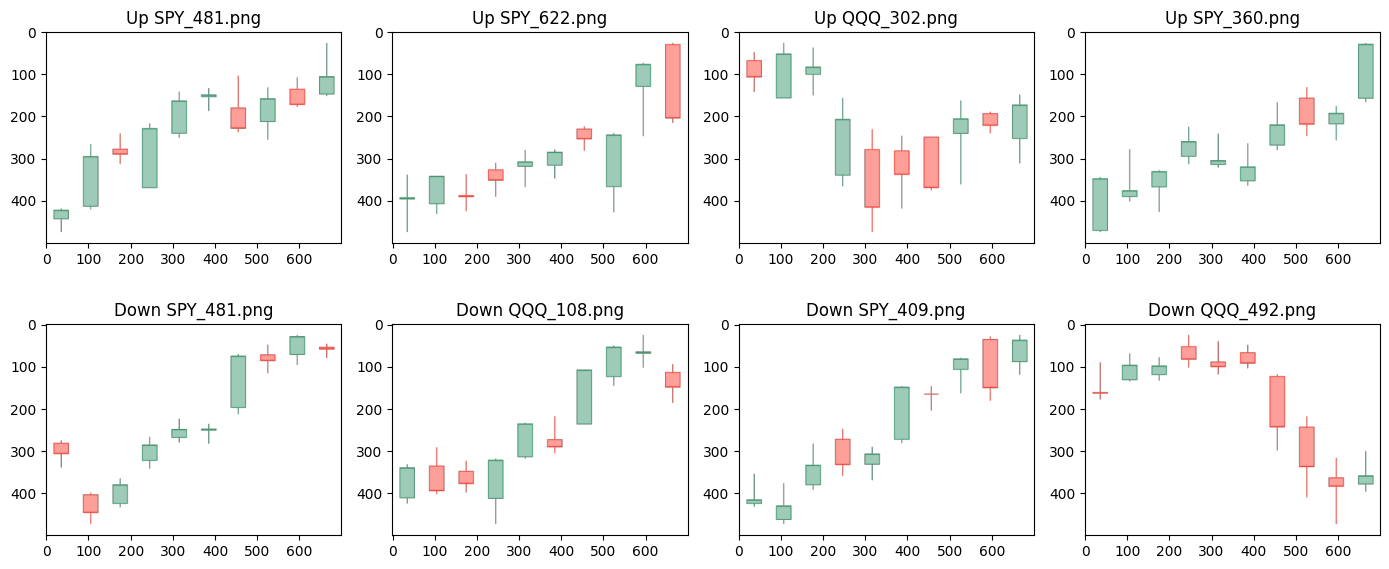

In [4]:
# display sample images
# Top row → UP, Bottom row → DOWN
def show_samples(base_path):
    classes = ['Up', 'Down']
    fig, axes = plt.subplots(2, 4, figsize=(14, 6))

    for row, cls in enumerate(classes):
        cls_path = os.path.join(base_path, cls)
        images = os.listdir(cls_path)[:4]

        for col, img_name in enumerate(images):
            img_path = os.path.join(cls_path, img_name)
            img = plt.imread(img_path)
            axes[row, col].imshow(img)
            axes[row, col].axis('on')
            axes[row, col].set_title(cls+" "+img_name)

    plt.tight_layout()
    plt.show()

show_samples(train_ds_path)

### Data Augmentation

In **candlestick chart images**, the goal of data augmentation is to **add small, realistic variations without changing the market meaning**.

**Why zooming, shifting, rotation are OK**

* **Small rotation (±10°)**: simulates slightly different chart orientations or capture noise without changing price relationships.
* **Zooming (±10%)**: mimics different time-window scales while preserving the trend structure.
* **Width/height shifts**: represent minor cropping or alignment differences; the relative candle order stays the same.
* **Brightness change**: simulates different rendering styles or lighting without affecting price patterns.

These augmentations **preserve the semantic meaning** of the candlestick patterns.

**Why horizontal or vertical flip is NOT OK**

* **Horizontal flip** reverses time → future appears as past, which is invalid in financial data.
* **Vertical flip** inverts prices → bullish patterns become bearish (high ↔ low), completely changing the market signal.

So in short:

> **Allowed augmentations add noise without changing financial meaning; flips distort time or price direction, breaking the logic of candlestick patterns.**


In [5]:
# Data Augmentation

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255, # scale image
    rotation_range=10, # rotate
    zoom_range=0.1, # zoom
    width_shift_range=0.05, # width shift
    height_shift_range=0.05, # height shift
    brightness_range=[0.9,1.1],
    horizontal_flip=False
)

test_datagen = ImageDataGenerator(rescale=1./255)


In [6]:
# Image dataLoaders

train_gen = train_datagen.flow_from_directory(
    train_ds_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=True
)

test_gen = test_datagen.flow_from_directory(
    test_ds_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

print(train_gen.class_indices)


Found 1433 images belonging to 2 classes.
Found 351 images belonging to 2 classes.
{'Down': 0, 'Up': 1}


UP Augmentations


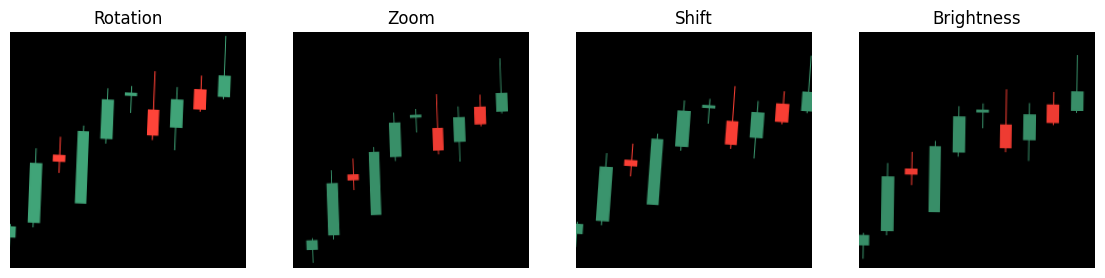

DOWN Augmentations


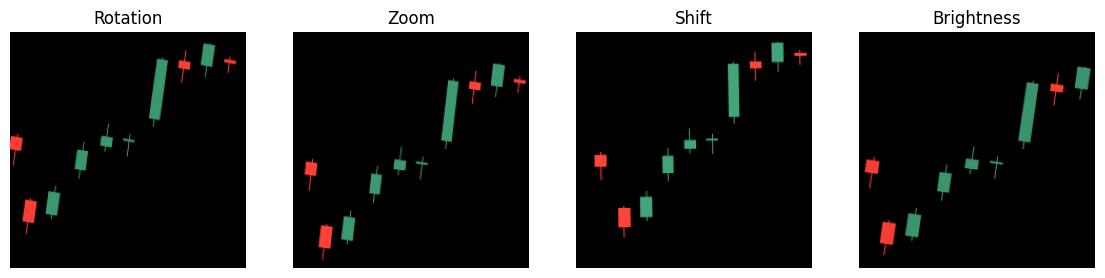

In [7]:
# Visualize Augmentations

def show_augmentations(class_name):
    img_path = os.path.join(train_ds_path, class_name)
    img_name = os.listdir(img_path)[0]
    img = tf.keras.preprocessing.image.load_img(
        os.path.join(img_path, img_name),
        target_size=IMG_SIZE
    ) # load image
    img = tf.keras.preprocessing.image.img_to_array(img) # convert to array
    img = img.reshape((1,) + img.shape) # reshape

    aug_iter = train_datagen.flow(img, batch_size=1) # data augmentation

    fig, axes = plt.subplots(1, 4, figsize=(14,4))
    titles = ["Rotation", "Zoom", "Shift", "Brightness"]

    for i in range(4):
        aug_img = next(aug_iter)[0]
        axes[i].imshow(aug_img)
        axes[i].set_title(titles[i])
        axes[i].axis('off')

    plt.show()

print("UP Augmentations")
show_augmentations('Up')

print("DOWN Augmentations")
show_augmentations('Down')

## Model Building & Training

**We tried three types of models:**

1. **Basic CNN (from scratch)**

   * Simple convolution + pooling layers.
   * Learns low-level candlestick features (edges, shapes).
   * Used as a **baseline** to see if patterns can be learned at all.

2. **Regularized CNN (improved from scratch)**

   * Adds **Batch Normalization** and **Dropout**.
   * Helps reduce overfitting and stabilizes training.
   * Learns more robust candlestick features than the basic CNN.

3. **Transfer Learning (ResNet50)**

   * Uses a **pretrained ResNet50** (ImageNet) as a feature extractor.
   * CNN backbone is frozen; only the custom classification head is trained.
   * Leverages **strong visual features** (edges, textures, shapes) to improve performance with limited data.

> We progressed from **simple → regularized → pretrained deep model** to compare learning from scratch vs. using powerful pretrained representations for candlestick pattern classification.


In [12]:
# models and helper functions

def build_basic_cnn():
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', input_shape=(*IMG_SIZE,3)),
        layers.MaxPooling2D(2,2),

        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D(2,2),

        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

def build_regularized_cnn():
    model = models.Sequential([
        layers.Conv2D(32, (3,3), padding='same', input_shape=(*IMG_SIZE,3)),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D(),

        layers.Conv2D(64, (3,3), padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D(),

        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])
    return model


def plot_history(history):
    fig, axes = plt.subplots(1,2, figsize=(14,5))

    axes[0].plot(history.history['accuracy'], label='Train')
    axes[0].plot(history.history['val_accuracy'], label='Test')
    axes[0].set_title('Accuracy')
    axes[0].legend()

    axes[1].plot(history.history['loss'], label='Train')
    axes[1].plot(history.history['val_loss'], label='Test')
    axes[1].set_title('Loss')
    axes[1].legend()

    plt.show()

In [9]:
# check for GPU Compatibility

import tensorflow as tf

print("TensorFlow version:", tf.__version__)

gpus = tf.config.list_physical_devices('GPU')

if gpus:
    print("GPUs detected:", gpus)
else:
    print("❌ No GPU detected")
    
with tf.device('/GPU:0'):
    a = tf.random.normal([1000,1000])
    b = tf.random.normal([1000,1000])
    c = tf.matmul(a, b)

print("Matrix multiplication completed")


TensorFlow version: 2.19.0
GPUs detected: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Matrix multiplication completed


I0000 00:00:1767375878.565106      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 186624)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    23,888,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,907,521 (91.20 MB)

 Trainable params: 23,907,521 (91.20 MB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15


I0000 00:00:1767375894.798313     154 service.cc:152] XLA service 0x7db6dc004700 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1767375894.798349     154 service.cc:160]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1767375895.188856     154 cuda_dnn.cc:529] Loaded cuDNN version 91002


 1/45 ━━━━━━━━━━━━━━━━━━━━ 4:02 6s/step - accuracy: 0.5000 - loss: 0.6944

I0000 00:00:1767375898.566734     154 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


45/45 ━━━━━━━━━━━━━━━━━━━━ 34s 637ms/step - accuracy: 0.5297 - loss: 0.7444 - val_accuracy: 0.5527 - val_loss: 0.6882
Epoch 2/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 21s 474ms/step - accuracy: 0.5600 - loss: 0.6862 - val_accuracy: 0.5527 - val_loss: 0.6880
Epoch 3/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 21s 477ms/step - accuracy: 0.5631 - loss: 0.6846 - val_accuracy: 0.5527 - val_loss: 0.6894
Epoch 4/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 22s 485ms/step - accuracy: 0.5492 - loss: 0.6843 - val_accuracy: 0.5527 - val_loss: 0.6875
Epoch 5/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 21s 473ms/step - accuracy: 0.5520 - loss: 0.6877 - val_accuracy: 0.5527 - val_loss: 0.6918
Epoch 6/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 22s 479ms/step - accuracy: 0.5528 - loss: 0.6871 - val_accuracy: 0.5499 - val_loss: 0.6911
Epoch 7/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 21s 475ms/step - accuracy: 0.5655 - loss: 0.6795 - val_accuracy: 0.5527 - val_loss: 0.7107
Epoch 8/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 22s 478ms/step - accuracy: 0.5684 - loss: 0.6801 - val_accuracy: 0.555

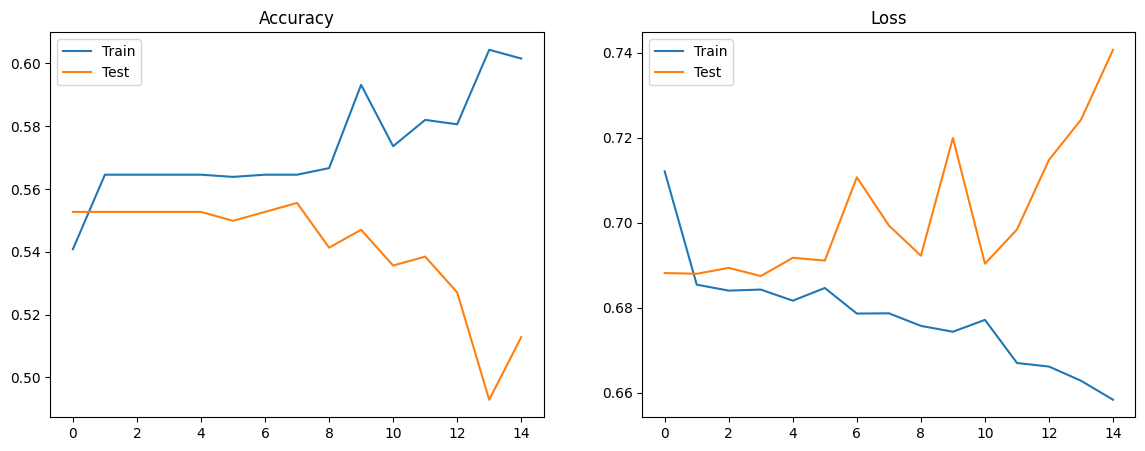

In [10]:
# Base Model

basic_model = build_basic_cnn()
basic_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

basic_model.summary()

EPOCHS = 15

base_history = basic_model.fit(
    train_gen,
    validation_data=test_gen,
    epochs=EPOCHS
)

plot_history(base_history)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 200704)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │    51,380,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,400,513 (196.08 MB)

 Trainable params: 51,400,321 (196.08 MB)

 Non-trainable params: 192 (768.00 B)

Epoch 1/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 27s 513ms/step - accuracy: 0.5367 - loss: 25.5425 - val_accuracy: 0.5356 - val_loss: 0.6930
Epoch 2/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 22s 478ms/step - accuracy: 0.5143 - loss: 0.7568 - val_accuracy: 0.5527 - val_loss: 0.6915
Epoch 3/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 21s 476ms/step - accuracy: 0.5684 - loss: 0.6894 - val_accuracy: 0.5527 - val_loss: 0.6895
Epoch 4/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 22s 488ms/step - accuracy: 0.5451 - loss: 0.6907 - val_accuracy: 0.5527 - val_loss: 0.6904
Epoch 5/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 23s 514ms/step - accuracy: 0.5606 - loss: 0.6901 - val_accuracy: 0.5527 - val_loss: 0.6895
Epoch 6/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 22s 493ms/step - accuracy: 0.5726 - loss: 0.6806 - val_accuracy: 0.5527 - val_loss: 0.6914
Epoch 7/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 22s 478ms/step - accuracy: 0.5647 - loss: 0.6836 - val_accuracy: 0.5527 - val_loss: 0.6893
Epoch 8/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 22s 480ms/step - accuracy: 0.5789 - loss: 0.6817 - val_acc

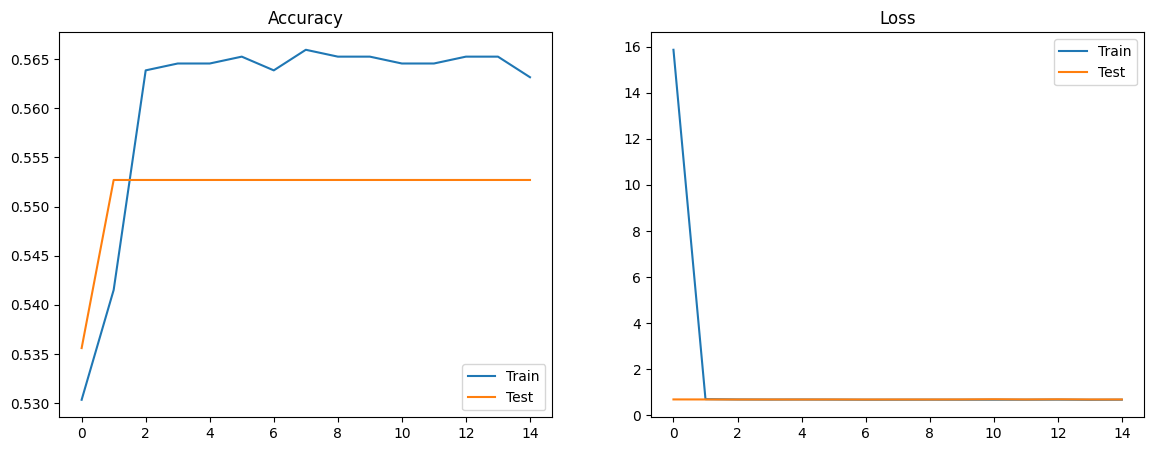

In [13]:

reg_model = build_regularized_cnn()
reg_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

reg_model.summary()

EPOCHS = 15

history = reg_model.fit(
    train_gen,
    validation_data=test_gen,
    epochs=EPOCHS
)

plot_history(history)

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_4[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,120,705 (92.01 MB)

 Trainable params: 528,897 (2.02 MB)

 Non-trainable params: 23,591,808 (90.00 MB)

Epoch 1/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 44s 735ms/step - accuracy: 0.5072 - loss: 0.7229 - val_accuracy: 0.4473 - val_loss: 0.7059
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 22s 494ms/step - accuracy: 0.5598 - loss: 0.6889 - val_accuracy: 0.4701 - val_loss: 0.6954
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 22s 483ms/step - accuracy: 0.5376 - loss: 0.7013 - val_accuracy: 0.5043 - val_loss: 0.6941
Epoch 4/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 0.5763 - loss: 0.6894 - val_accuracy: 0.5527 - val_loss: 0.6887
Epoch 5/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 26s 583ms/step - accuracy: 0.5558 - loss: 0.7014 - val_accuracy: 0.5527 - val_loss: 0.6886
Epoch 6/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 22s 489ms/step - accuracy: 0.5772 - loss: 0.6743 - val_accuracy: 0.5271 - val_loss: 0.6899
Epoch 7/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 22s 483ms/step - accuracy: 0.5839 - loss: 0.6791 - val_accuracy: 0.5499 - val_loss: 0.6887
Epoch 8/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 22s 484ms/step - accuracy: 0.5837 - loss: 0.6850 - val_accurac

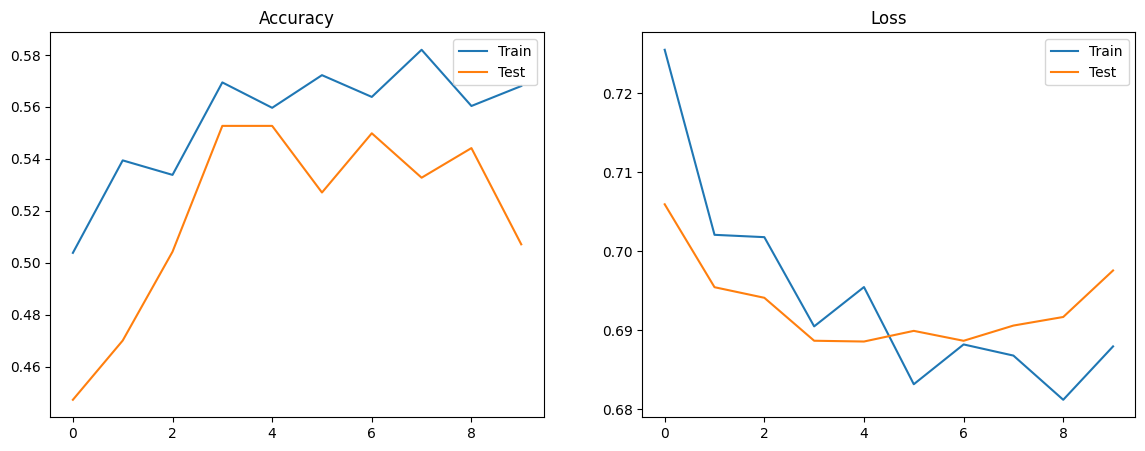

In [15]:
# Transfer Learning

resnet = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(*IMG_SIZE,3)
)
resnet.trainable = False

x = resnet.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
output = layers.Dense(1, activation='sigmoid')(x)

resnet_model = models.Model(resnet.input, output)

resnet_model.compile(
    optimizer=optimizers.Adam(1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

resnet_model.summary()

resnet_history = resnet_model.fit(
    train_gen,
    validation_data=test_gen,
    epochs=10
)

plot_history(resnet_history)

11/11 ━━━━━━━━━━━━━━━━━━━━ 9s 490ms/step
              precision    recall  f1-score   support

           0       0.38      0.15      0.22       157
           1       0.54      0.79      0.64       194

    accuracy                           0.51       351
   macro avg       0.46      0.47      0.43       351
weighted avg       0.46      0.51      0.45       351

F1 Score: 0.6403326403326404
ROC AUC: 0.48483157134414606


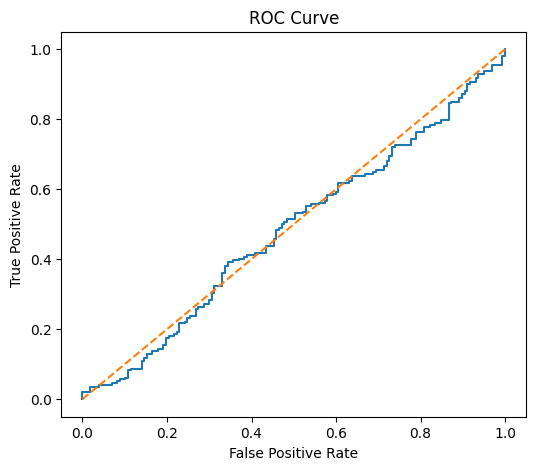

In [16]:
y_true = test_gen.classes
y_prob = resnet_model.predict(test_gen).ravel()
y_pred = (y_prob > 0.5).astype(int)

print(classification_report(y_true, y_pred))
print("F1 Score:", f1_score(y_true, y_pred))
print("ROC AUC:", roc_auc_score(y_true, y_prob))

fpr, tpr, _ = roc_curve(y_true, y_prob)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr)
plt.plot([0,1], [0,1], linestyle='--')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()


## **Observations**

The **ResNet model shows weak overall performance**. Although class 1 has **high recall (0.79)** and a decent **F1 score (~0.64)**, this comes at the cost of **poor class 0 detection**, indicating a strong **class bias**. The **overall accuracy (~51%)** and **ROC-AUC (<0.5)** suggest the model is **close to random guessing** and fails to separate classes reliably.

Compared to this, the **baseline/regularized CNN achieves slightly better and more balanced validation accuracy (~55%)**, indicating that **transfer learning did not provide a clear advantage** for this candlestick dataset, possibly due to domain mismatch or limited fine-tuning.


## Error Analysis

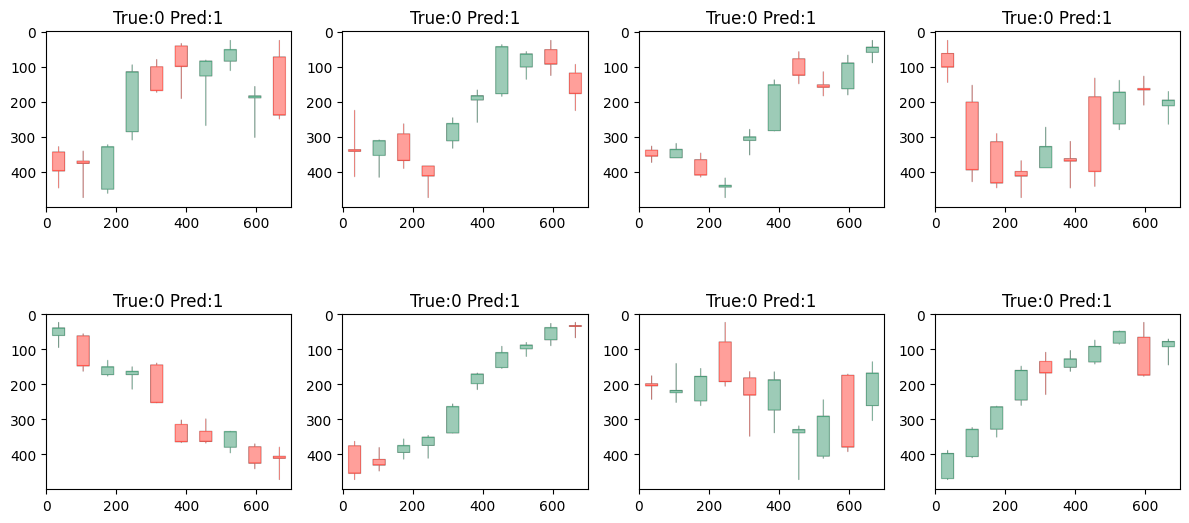

In [18]:
# Error Analysis

errors = np.where(y_pred != y_true)[0]

plt.figure(figsize=(12,6))
for i, idx in enumerate(errors[:8]):
    plt.subplot(2,4,i+1)
    img_path = test_gen.filepaths[idx]
    img = plt.imread(img_path)
    plt.imshow(img)
    plt.axis('on')
    plt.title(f"True:{y_true[idx]} Pred:{y_pred[idx]}")

plt.tight_layout()
plt.show()


**Short summary of work done:**

* **Data transformations:**
  Candlestick images were resized and normalized, with light augmentation (small rotations, zoom, shifts, brightness changes) to improve generalization while preserving financial meaning; flips were avoided to prevent distorting time or price direction.

* **Models used:**

  1. A **basic CNN** trained from scratch as a baseline,
  2. A **regularized CNN** with Batch Normalization and Dropout to reduce overfitting,
  3. A **transfer-learning model (ResNet50)** used as a frozen feature extractor with a custom classification head.

* **Results:**
  The baseline and regularized CNNs achieved around **55% validation accuracy**.
  The ResNet50 model showed **high recall for one class but poor overall discrimination**, with ~**51% accuracy** and **ROC-AUC < 0.5**, indicating performance close to random and no clear advantage from transfer learning.
